In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from model_simulator import ARXSimulator
from mpc_controller import MPCController
from plotly.subplots import make_subplots
from tqdm import tqdm
import random
%load_ext autoreload

In [40]:
B = [-0.00091497,  0.14029288]
A = [-1.04411331, 0.00942735,  0.00399007,  0.05331014]

horizon = 8
P = 0.1
Q = 1e3

# initialize array to store simulation results
t_sim = 288
u_past_sim = np.zeros(4)
# u_past_sim = np.ones(4) * 12
y_past_sim = np.ones(4) * 20
y_ref_sim = np.array([])
y_ref = 45
mpc = MPCController(A, B, P, Q, horizon)
arx = ARXSimulator(A, B, y_past_sim, u_past_sim[-2:])

In [41]:
y_ref_sim = np.append(y_ref_sim, y_past_sim)
for t in tqdm(range(0,t_sim)):
    # print('u_past_sim: ', u_past_sim)
    # print('y_past_sim: ', y_past_sim)

    u_sim, y_sim = mpc.simulate(u_past_sim[-2:], y_past_sim[-4:], y_ref)
    if u_sim is  None:
        break
    u_past_sim = np.append(u_past_sim, u_sim[len(A)])
    mwh_hat = arx.MW_to_MWh([u_sim[len(A)]])
    y_past_sim = np.append(y_past_sim, mwh_hat)
    y_ref_sim = np.append(y_ref_sim,y_ref)
    if t % 8 ==0 and t > 0:
        y_ref = random.choice([45, 20, 60, 15])


100%|██████████| 288/288 [00:13<00:00, 20.86it/s]


In [28]:
len(u_past_sim)

100

In [ ]:
len(y_past_sim)

In [32]:
len(y_ref_sim)

100

Horizon (hours):  2.0  P:  0.1  Q:  1000.0


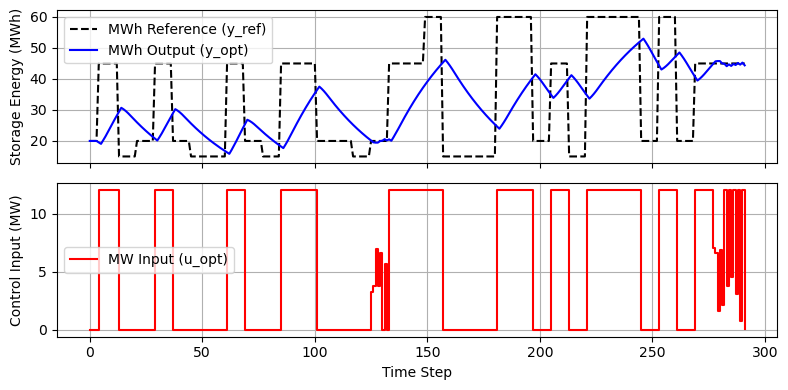

In [42]:
print('Horizon (hours): ', horizon/4, ' P: ', P, ' Q: ', Q )

time = range(len(y_past_sim))
fig, axs = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

# Plot y_ref and y_output
axs[0].plot(time,y_ref_sim, label="MWh Reference (y_ref)", linestyle="--", color="black")
# axs[0].axhline(y_ref, label = 'Y- reference')
axs[0].plot(time, y_past_sim, label="MWh Output (y_opt)", color="blue")
axs[0].set_ylabel("Storage Energy (MWh)")
axs[0].legend()
axs[0].grid(True)

# Plot u_control
axs[1].step(time, u_past_sim, label="MW Input (u_opt)", where="post", color="red")
axs[1].set_xlabel("Time Step")
axs[1].set_ylabel("Control Input (MW)")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [37]:
# actual plots from the csv files
folder_path = r"D:\ms\January 2024\Thesis\Boiler-Bidding-model\Datasets\LinHeatSchedule_1week_estimatedMWh.csv"
schedule = pd.read_csv(folder_path)

In [44]:
fig = go.Figure()

# Add step plots
fig.add_trace(go.Scatter(x=schedule['UTC'], y=schedule['L11 Heat storage energy [MWh]'], mode='lines', line=dict(shape='hv', color='blue'), name="MWh"))
fig.add_trace(go.Scatter(x=schedule['UTC'], y=schedule['L11 EK plan [MW]'], mode='lines', line=dict(shape='hv', color='red'), name="Input MW", yaxis="y2"))
fig.add_trace(go.Scatter(x=schedule['UTC'], y=schedule['Heat load forecast [MW]'], mode='lines', line=dict(shape='hv', color='black'), name="Forecast MW", yaxis="y2"))

# Layout settings
fig.update_layout(
    title=" L11 Heat storage energy [MWh] and 'Heat load forecast [MW]'",
    xaxis_title="Time [15 min]",
    yaxis_title="L11 Heat storage energy [MWh]",
    yaxis2=dict(
        title="Heat Load [MW]",
        overlaying="y",
        side="right"
    ),
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    template="plotly_white"
)

# Show plot
fig.show()

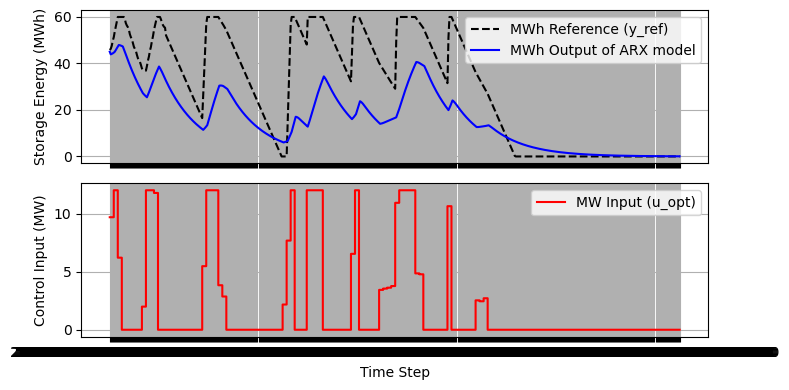

In [ ]:
# test Digital Twin (Model_simulator) using the schedule data
B = [-0.00091497,  0.14029288]
A = [-1.04411331, 0.00942735,  0.00399007,  0.05331014]
y_past_sim = schedule['L11 Heat storage energy [MWh]'][:4]
u_past_sim = schedule['L11 EK plan [MW]'][:4]
boiler_model = ARXSimulator(A, B, y_past_sim, u_past_sim[-2:])

Mwh_output = boiler_model.MW_to_MWh(schedule['L11 EK plan [MW]'][4:])


In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

# Plot y_ref and y_output
axs[0].plot(schedule['UTC'][4:],schedule['L11 Heat storage energy [MWh]'][4:], label="MWh Reference (y_ref)", linestyle="--", color="black")
axs[0].plot(schedule['UTC'][4:], Mwh_output, label="MWh Output of ARX model", color="blue")
axs[0].set_ylabel("Storage Energy (MWh)")
axs[0].legend()
axs[0].grid(True)

# Plot u_control
axs[1].step(schedule['UTC'][4:], schedule['L11 EK plan [MW]'][4:], label="MW Input (u_opt)", where="post", color="red")
axs[1].set_xlabel("Time Step")
axs[1].set_ylabel("Control Input (MW)")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# test MPC Controller using the schedule data
B = [-0.00091497,  0.14029288]
A = [-1.04411331, 0.00942735,  0.00399007,  0.05331014]

horizon = 8
P = 0.1
Q = 1e3

# initialize array to store simulation results
t_sim = 288
y_past_sim = schedule['L11 Heat storage energy [MWh]'][:4]
u_past_sim = schedule['L11 EK plan [MW]'][:4]

y_ref_sim = schedule['L11 Heat storage energy [MWh]'][4:]